# Homework 5: Weather Prediction

## Due Tues Mar 8, 2022 @ 8 pm

## Casey Lam, casey_lam@berkeley.edu

## Collaborators: #hw5-discussion channel

In this assignment we will create a database to analyze historical weather data and discovery the relationships between major cities.

### 1) Use the data supplied of airport codes (ICAO_airports.csv) and top airports (top_airports.csv) to make a table of 50 most travelled airports in the US and containing relevant information, like name, wikipedia link, latitude, longitude.

Note: I've commented out a lot of code in this section where I created and populated the tables, so I don't accidentally delete and overwrite things when I rerun the whole notebook.

In [1]:
import pandas as pd
import sqlite3

Load up the supplied data and take a look at what's in the tables.

In [2]:
icao = pd.read_csv('ICAO_airports.csv')
top = pd.read_csv('top_airports.csv')

In [3]:
icao.head(5)

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NaN,US,US-PA,Bensalem,no,00A,NaN,00A,NaN,NaN,NaN
1,6524,00AK,small_airport,Lowell Field,59.949200,-151.695999,450.0,NaN,US,US-AK,Anchor Point,no,00AK,NaN,00AK,NaN,NaN,NaN
2,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,00AL,NaN,00AL,NaN,NaN,NaN
3,6526,00AR,heliport,Newport Hospital & Clinic Heliport,35.608700,-91.254898,237.0,NaN,US,US-AR,Newport,no,00AR,NaN,00AR,NaN,NaN,NaN
4,6527,00AZ,small_airport,Cordes Airport,34.305599,-112.165001,3810.0,NaN,US,US-AZ,Cordes,no,00AZ,NaN,00AZ,NaN,NaN,NaN


In [4]:
top.head(5)

,City,FAA,IATA,ICAO,Airport,Role,Enplanements
0,Atlanta,ATL,ATL,KATL,Hartsfield-Jackson Atlanta International Airport,P-L,43130585
1,Chicago,ORD,ORD,KORD,Chicago O'Hare International Airport,P-L,32171831
2,Los Angeles,LAX,LAX,KLAX,Los Angeles International Airport,P-L,30528737
3,Dallas-Fort Worth,DFW,DFW,KDFW,Dallas/Fort Worth International Airport,P-L,27100656
4,Denver,DEN,DEN,KDEN,Denver International Airport,P-L,25241962


Create the database, make two tables (icao, top), and put the relevant information from each csv file into the tables. 

In [5]:
!rm airports.db

connection = sqlite3.connect("airports.db")

cursor = connection.cursor()

sql_cmd = """CREATE TABLE icao 
            (iid INTEGER  NOT NULL  PRIMARY KEY  AUTOINCREMENT DEFAULT 0, 
            name TEXT, 
            wikipedia_link TEXT, 
            iata TEXT, 
            latitude_deg FLOAT, 
            longitude_deg FLOAT)"""

cursor.execute(sql_cmd)

sql_cmd = """CREATE TABLE top 
            (tid INTEGER  NOT NULL  PRIMARY KEY  AUTOINCREMENT DEFAULT 0, 
            name TEXT, 
            iata TEXT)"""

cursor.execute(sql_cmd)
connection.commit()

In [6]:
icao = icao.where(pd.notnull(icao), None)
for ii, row in icao.iterrows():
    iparams = (row['name'], row['wikipedia_link'], row['iata_code'], row['latitude_deg'], row['longitude_deg'])
    sql_cmd = """INSERT INTO icao
                (name, wikipedia_link, iata, latitude_deg, longitude_deg)
                VALUES (?, ?, ?, ?, ?)"""
    
    cursor.execute(sql_cmd, iparams)
connection.commit()

In [7]:
top = top.where(pd.notnull(top), None)
for ii, row in top.iterrows():
    iparams = (row['Airport'], row['IATA'])
    sql_cmd = """INSERT INTO top
                (name, iata)
                VALUES (?, ?)"""
    
    cursor.execute(sql_cmd, iparams)
connection.commit()    

In [8]:
# #########
# # Just to test and make sure this works.
# #########

# sql_cmd = "SELECT * FROM icao WHERE longitude_deg > 0"
# cursor.execute(sql_cmd)

# db_info = cursor.fetchall()
# for entry in db_info:
#     print(entry)

Now use left join and save the output as a new table called icao_top, which now is a table of the 50 most travelled airports in the US containing the airport name, IATA, wikipedia link, latitude, and longitude.

In [9]:
sql_cmd = """CREATE TABLE icao_top AS
            SELECT top.name, top.iata, icao.wikipedia_link, icao.latitude_deg, icao.longitude_deg
            FROM top LEFT JOIN icao ON
            top.iata = icao.iata"""

cursor.execute(sql_cmd)
connection.commit()

In [10]:
#########
# Just to make sure it worked.
#########

sql_cmd = "SELECT * FROM icao_top"

cursor.execute(sql_cmd)

db_info = cursor.fetchall()
print(len(db_info))
for entry in db_info: 
    print(entry)

50
('Hartsfield-Jackson Atlanta International Airport', 'ATL', 'http://en.wikipedia.org/wiki/Hartsfield-Jackson_Atlanta_International_Airport', 33.6366996765137, -84.4281005859375)
("Chicago O'Hare International Airport", 'ORD', "http://en.wikipedia.org/wiki/O'Hare_International_Airport", 41.97859955, -87.90480042)
('Los Angeles International Airport', 'LAX', 'http://en.wikipedia.org/wiki/Los_Angeles_International_Airport', 33.94250107, -118.4079971)
('Dallas/Fort Worth International Airport', 'DFW', 'http://en.wikipedia.org/wiki/Dallas-Fort_Worth_International_Airport', 32.896800994873, -97.0380020141602)
('Denver International Airport', 'DEN', 'http://en.wikipedia.org/wiki/Denver_International_Airport', 39.8616981506348, -104.672996520996)
('John F. Kennedy International Airport', 'JFK', 'http://en.wikipedia.org/wiki/John_F._Kennedy_International_Airport', 40.63980103, -73.77890015)
('San Francisco International Airport', 'SFO', 'http://en.wikipedia.org/wiki/San_Francisco_Internation

### 2) Build another table that will hold historical weather information: min/max temperature, relative humidity, and precipitation.

In [11]:
sql_cmd = """CREATE TABLE weather
            (wid INTEGER  NOT NULL  PRIMARY KEY  AUTOINCREMENT DEFAULT 0, 
            date DATE,
            lat FLOAT,
            long FLOAT,
            min_temp FLOAT,
            max_temp FLOAT,
            min_relhumid FLOAT,
            max_relhumid FLOAT,
            precip FLOAT)"""
cursor.execute(sql_cmd)
connection.commit()

### 3) Using the data from the xarray/netCDF4 example in class, populate the database from 1990-2000.

In [12]:
import xarray as xr
import numpy as np

Grab all the data we want (min/max temp, relative humidity, precipitation) from the online catalog.

In [13]:
# temp: tasmax/tasmin, RH: rhsmax/rhsmin, precipitation: pr
# downward shortwave solar radiation(rsds), eastward wind(uas), 
# northward wind(vas), and specific humidity(huss)

datatype = "tasmax" 

data_path = ("http://thredds.northwestknowledge.net:8080/"
             f"thredds/dodsC/agg_macav2metdata_{datatype}"
             "_BNU-ESM_r1i1p1_historical_1950_2005_CONUS_daily.nc")

max_temp_xr_all = xr.open_dataset(data_path)  
max_temp_xr = max_temp_xr_all['air_temperature'].sel(time=slice("1990", "2000"))

In [14]:
datatype = "tasmin" 

data_path = ("http://thredds.northwestknowledge.net:8080/"
             f"thredds/dodsC/agg_macav2metdata_{datatype}"
             "_BNU-ESM_r1i1p1_historical_1950_2005_CONUS_daily.nc")

min_temp_xr_all = xr.open_dataset(data_path)  
min_temp_xr = min_temp_xr_all['air_temperature'].sel(time=slice("1990", "2000"))

In [15]:
datatype = "rhsmax" 

data_path = ("http://thredds.northwestknowledge.net:8080/"
             f"thredds/dodsC/agg_macav2metdata_{datatype}"
             "_BNU-ESM_r1i1p1_historical_1950_2005_CONUS_daily.nc")

max_rhum_xr_all = xr.open_dataset(data_path) 
max_rhum_xr = max_rhum_xr_all['relative_humidity'].sel(time=slice("1990", "2000"))

In [16]:
datatype = "rhsmin" 

data_path = ("http://thredds.northwestknowledge.net:8080/"
             f"thredds/dodsC/agg_macav2metdata_{datatype}"
             "_BNU-ESM_r1i1p1_historical_1950_2005_CONUS_daily.nc")

min_rhum_xr_all = xr.open_dataset(data_path) 
min_rhum_xr = min_rhum_xr_all['relative_humidity'].sel(time=slice("1990", "2000"))

In [17]:
datatype = "pr" 

data_path = ("http://thredds.northwestknowledge.net:8080/"
             f"thredds/dodsC/agg_macav2metdata_{datatype}"
             "_BNU-ESM_r1i1p1_historical_1950_2005_CONUS_daily.nc")

precip_xr_all = xr.open_dataset(data_path) 
precip_xr = precip_xr_all['precipitation'].sel(time=slice("1990", "2000"))

Load up the database (which was created in the commented out code above).

In [18]:
# connection = sqlite3.connect("airports.db")

# cursor = connection.cursor()

Just get the longitudes and latitudes that match, otherwise it will take forever to make the database.

In [19]:
lon_arr = np.zeros(50)
lat_arr = np.zeros(50)

sql_cmd = "SELECT latitude_deg, longitude_deg FROM icao_top"

cursor.execute(sql_cmd)
db_info = cursor.fetchall()
for ii, entry in enumerate(db_info): 
    lat_arr[ii] = entry[0]
    lon_arr[ii] = entry[1]

In [20]:
idx = np.where((lon_arr + 360 > precip_xr['lon'].values.min() - 0.04) &
         (lon_arr + 360 < precip_xr['lon'].values.max() + 0.04) &
         (lat_arr > precip_xr['lat'].values.min() - 0.04) &
         (lat_arr < precip_xr['lat'].values.max() + 0.04))[0]
print(len(idx))

lon_arr = lon_arr[idx]
lat_arr = lat_arr[idx]
n_good = len(idx)

48


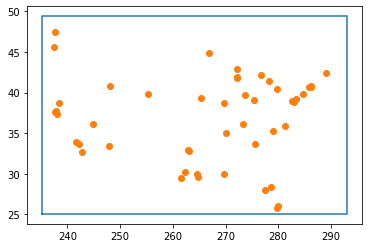

In [24]:
lon_idx_arr = []
lat_idx_arr = []

for ii, lon in enumerate(lon_arr):
    lon_idx_arr.append(np.abs(precip_xr['lon'].values - (lon + 360)).argmin())

for ii, lat in enumerate(lat_arr):
    lat_idx_arr.append(np.abs(precip_xr['lat'].values - lat).argmin())
    
# Note there are two places they don't match up. It's obvious when plotting.
#np.diff(precip_xr['lat']).mean()
#np.diff(precip_xr['lon']).mean()

lonidx = np.where(precip_xr['lon'].values[lon_idx_arr] - (lon_arr + 360) > 0.04)[0]
latidx = np.where(precip_xr['lat'].values[lat_idx_arr] - lat_arr > 0.04)[0]

import matplotlib.pyplot as plt

plt.plot([precip_xr['lon'].min(), precip_xr['lon'].min(), precip_xr['lon'].max(), precip_xr['lon'].max(), precip_xr['lon'].min()],
         [precip_xr['lat'].min(), precip_xr['lat'].max(), precip_xr['lat'].max(), precip_xr['lat'].min(), precip_xr['lat'].min()])
plt.plot(lon_arr + 360, lat_arr, 'o')

Put into database.

In [25]:
# ~1000 seconds to write the table.
import time
t1 = time.time()
for ii in np.arange(n_good):
    lon_idx = lon_idx_arr[ii]
    lat_idx = lat_idx_arr[ii]
    lat = min_temp_xr.isel(lon=lon_idx, lat=lat_idx)['lat'].values
    lon = min_temp_xr.isel(lon=lon_idx, lat=lat_idx)['lon'].values
    min_temp = min_temp_xr.isel(lon=lon_idx, lat=lat_idx).values
    max_temp = max_temp_xr.isel(lon=lon_idx, lat=lat_idx).values
    min_rhum = min_rhum_xr.isel(lon=lon_idx, lat=lat_idx).values
    max_rhum = max_rhum_xr.isel(lon=lon_idx, lat=lat_idx).values
    precip = precip_xr.isel(lon=lon_idx, lat=lat_idx).values
    for jj, time_xr in enumerate(precip_xr['time']):
        params = (str(time_xr.dt.strftime('%Y-%m-%d').values),
                  float(lat_arr[ii]),
                  float(lon_arr[ii]),
                  float(min_temp[jj]),
                  float(max_temp[jj]),
                  float(min_rhum[jj]),
                  float(max_rhum[jj]),
                  float(precip[jj]))
        sql_cmd = """INSERT INTO weather
                    (date, lat, long, min_temp, max_temp, min_relhumid, max_relhumid, precip)
                    VALUES (?, ?, ?, ?, ?, ?, ?, ?)"""
    
        cursor.execute(sql_cmd, params)
connection.commit()
t2 = time.time()

print(t2 - t1)

921.2018775939941


In [ ]:
# ngood = 48

# lon_arr = np.zeros(ngood)
# lat_arr = np.zeros(ngood)

# sql_cmd = """SELECT latitude_deg, longitude_deg FROM icao_top 
#              WHERE longitude_deg > -124.77215576 AND
#                    longitude_deg < -67.0647583 AND
#                    latitude_deg > 25.06307793 AND
#                    latitude_deg < 49.3960228"""

# cursor.execute(sql_cmd)
# db_info = cursor.fetchall()
# for ii, entry in enumerate(db_info): 
#     lat_arr[ii] = entry[0]
#     lon_arr[ii] = entry[1]
        
# sql_cmd = """CREATE TABLE weather
#             (wid INTEGER  NOT NULL  PRIMARY KEY  AUTOINCREMENT DEFAULT 0, 
#             date DATE,
#             lat FLOAT,
#             long FLOAT,
#             min_temp FLOAT,
#             max_temp FLOAT,
#             min_relhumid FLOAT,
#             max_relhumid FLOAT,
#             precip FLOAT)"""
# cursor.execute(sql_cmd)
# connection.commit()

# # ~1000 seconds to write the table.
# import time
# t1 = time.time()
# for ii in np.arange(48):
#     lon_idx = lon_idx_arr[ii]
#     lat_idx = lat_idx_arr[ii]
#     lat = min_temp_xr.isel(lon=lon_idx, lat=lat_idx)['lat'].values
#     lon = min_temp_xr.isel(lon=lon_idx, lat=lat_idx)['lon'].values
#     min_temp = min_temp_xr.isel(lon=lon_idx, lat=lat_idx).values
#     max_temp = max_temp_xr.isel(lon=lon_idx, lat=lat_idx).values
#     min_rhum = min_rhum_xr.isel(lon=lon_idx, lat=lat_idx).values
#     max_rhum = max_rhum_xr.isel(lon=lon_idx, lat=lat_idx).values
#     precip = precip_xr.isel(lon=lon_idx, lat=lat_idx).values
#     for jj, time_xr in enumerate(precip_xr['time']):
#         params = (str(time_xr.dt.strftime('%Y-%m-%d').values),
#                   float(lat_arr[ii]),
#                   float(lon_arr[ii]),
#                   float(min_temp[jj]),
#                   float(max_temp[jj]),
#                   float(min_rhum[jj]),
#                   float(max_rhum[jj]),
#                   float(precip[jj]))
#         sql_cmd = """INSERT INTO weather
#                     (date, lat, long, min_temp, max_temp, min_relhumid, max_relhumid, precip)
#                     VALUES (?, ?, ?, ?, ?, ?, ?, ?)"""
    
#         cursor.execute(sql_cmd, params)
# connection.commit()
# t2 = time.time()

# print(t2 - t1)

In [ ]:
# print(lat_arr[0], lon_arr[0])
# print(lat_arr[1], lon_arr[1])

In [ ]:
# print(precip_xr['lon'].min() - 360)
# print(precip_xr['lon'].max() - 360)
# print(precip_xr['lat'].min())
# print(precip_xr['lat'].max())

# ngood = len(db_info)

# lon_arr = np.zeros(ngood)
# lat_arr = np.zeros(ngood)

# sql_cmd = """SELECT latitude_deg, longitude_deg FROM icao_top 
#              WHERE longitude_deg > -124.77215576 AND
#                    longitude_deg < -67.0647583 AND
#                    latitude_deg > 25.06307793 AND
#                    latitude_deg < 49.3960228"""

# cursor.execute(sql_cmd)
# db_info = cursor.fetchall()
# for ii, entry in enumerate(db_info): 
#     lat_arr[ii] = entry[0]
#     lon_arr[ii] = entry[1]

In [ ]:
# len(np.where((precip_xr['lon'] - 360 > -124.77215576) & (precip_xr['lon'] - 360 < -67.0647583))[0])

In [ ]:
# sql_cmd = "SELECT * FROM weather_new"
# cursor.execute(sql_cmd)

# db_info = cursor.fetchall()
# print(len(db_info))
# for ee, entry in enumerate(db_info):
#     print(entry)

### 4) For each pair of cities/airports determine how the daily change of temperature high and precipitation from one city predicts the daily change of the other city 1, 3, & 7 days in advance. (Note: for correlations between pairs, try np.corrcoef.)

In [29]:
max_temp_arr = np.empty((n_good, 4018))

precip_arr = np.empty((n_good, 4018))

for ii in np.arange(n_good):
    sql_cmd = "SELECT max_temp, precip FROM weather WHERE lat={0} AND long={1} ORDER BY date".format(lat_arr[ii], lon_arr[ii])
    cursor.execute(sql_cmd)

    db_info = cursor.fetchall()
    for ee, entry in enumerate(db_info):
        max_temp_arr[ii, ee] = entry[0]
        precip_arr[ii, ee] = entry[1]

In [31]:
import itertools
combos = list(itertools.combinations(np.arange(n_good), 2))

d0 = np.empty(len(combos))
d1 = np.empty(len(combos))
d3 = np.empty(len(combos))
d7 = np.empty(len(combos))

In [32]:
for ii in np.arange(len(combos)):
    idx1 = combos[ii][0]
    idx2 = combos[ii][1]
    d0[ii] = np.corrcoef(np.diff(max_temp_arr[idx1]), np.diff(max_temp_arr[idx2]))[0,1]
    d1[ii] = np.corrcoef(np.diff(max_temp_arr[idx1])[1:], np.diff(max_temp_arr[idx2])[:-1])[0,1]
    d3[ii] = np.corrcoef(np.diff(max_temp_arr[idx1])[3:], np.diff(max_temp_arr[idx2])[:-3])[0,1]
    d7[ii] = np.corrcoef(np.diff(max_temp_arr[idx1])[7:], np.diff(max_temp_arr[idx2])[:-7])[0,1]

In [33]:
sep = np.empty(len(combos))
dlon = np.empty(len(combos))

lat_arr_rad = np.deg2rad(lat_arr)
lon_arr_rad = np.deg2rad(lon_arr)

for ii in np.arange(len(combos)):
    idx1 = combos[ii][0]
    idx2 = combos[ii][1]
    lat1 = lat_arr_rad[idx1]
    lat2 = lat_arr_rad[idx2]
    lon1 = lon_arr_rad[idx1]
    lon2 = lon_arr_rad[idx2]
    term1 = np.sin(0.5 * (lat2 - lat1))**2
    term2 = np.cos(lat1) * np.cos(lat2) * np.sin(0.5 * (lon2 - lon1))**2
    sep[ii] = np.arcsin(np.sqrt(term1 + term2))
    dlon[ii] = lon2 - lon1

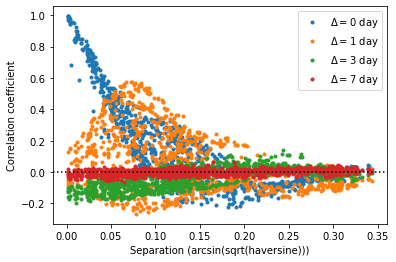

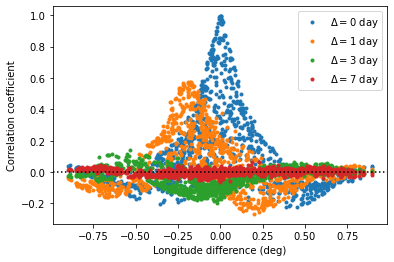

In [34]:
plt.figure(1)
plt.clf()
plt.plot(sep, d0, '.', label='$\Delta = 0$ day')
plt.plot(sep, d1, '.', label='$\Delta = 1$ day')
plt.plot(sep, d3, '.', label='$\Delta = 3$ day')
plt.plot(sep, d7, '.', label='$\Delta = 7$ day')
plt.legend()
plt.xlabel('Separation (arcsin(sqrt(haversine)))')
plt.ylabel('Correlation coefficient')
plt.axhline(y=0, color='k', ls = ':')

plt.figure(2)
plt.clf()
plt.plot(dlon, d0, '.', label='$\Delta = 0$ day')
plt.plot(dlon, d1, '.', label='$\Delta = 1$ day')
plt.plot(dlon, d3, '.', label='$\Delta = 3$ day')
plt.plot(dlon, d7, '.', label='$\Delta = 7$ day')
plt.legend()
plt.xlabel('Longitude difference (deg)')
plt.ylabel('Correlation coefficient')
plt.axhline(y=0, color='k', ls = ':')

### 5) Plot the correlation strengths for the 10 top pairs for all three dates, for temperature and precipitation (separately) as a function of distance. Also make a plot as a function of longitude different. What trends do you see?

In [37]:
d0_sortidx = np.argsort(d0)
d1_sortidx = np.argsort(d1)
d3_sortidx = np.argsort(d3)
d7_sortidx = np.argsort(d7)

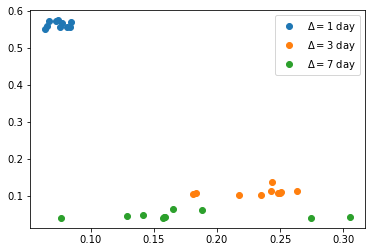

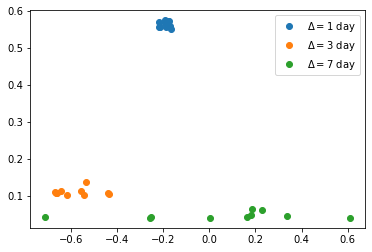

In [38]:
plt.figure(1)
plt.clf()
plt.plot(sep[d1_sortidx][::-1][0:10], d1[d1_sortidx][::-1][0:10], 'o', label='$\Delta = 1$ day')
plt.plot(sep[d3_sortidx][::-1][0:10], d3[d3_sortidx][::-1][0:10], 'o', label='$\Delta = 3$ day')
plt.plot(sep[d7_sortidx][::-1][0:10], d7[d7_sortidx][::-1][0:10], 'o', label='$\Delta = 7$ day')
plt.legend()

plt.figure(2)
plt.clf()
plt.plot(dlon[d1_sortidx][::-1][0:10], d1[d1_sortidx][::-1][0:10], 'o', label='$\Delta = 1$ day')
plt.plot(dlon[d3_sortidx][::-1][0:10], d3[d3_sortidx][::-1][0:10], 'o', label='$\Delta = 3$ day')
plt.plot(dlon[d7_sortidx][::-1][0:10], d7[d7_sortidx][::-1][0:10], 'o', label='$\Delta = 7$ day')
plt.legend()